8792
8968


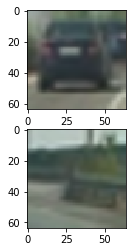

In [1]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt


def load_images(dir):
    rv = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for fn in sorted(filenames):
            if fn.endswith('.png'):
                imdata = cv2.imread(os.path.join(dirpath, fn))
                imdata = cv2.cvtColor(imdata, cv2.COLOR_BGR2RGB)
                rv.append(imdata)
    
    return rv


vehicles_unshuffled = load_images('vehicles')
non_vehicles_unshuffled = load_images('non-vehicles')

print(len(vehicles_unshuffled))
print(len(non_vehicles_unshuffled))
_, (ax1, ax2) = plt.subplots(2)
ax1.imshow(vehicles_unshuffled[0])
ax2.imshow(non_vehicles_unshuffled[1])

In [2]:
import itertools
import random


def block_shuffle(l, block_size, random=random):
    blocks = list(itertools.zip_longest(*[iter(l)]*block_size))
    blocks[-1] = [im for im in blocks[-1] if im is not None]
    random.shuffle(blocks)
    return list(itertools.chain.from_iterable(blocks))

# in GTI dataset, vehicles typically appear for up to 15 frames. So, we do a block shuffle with block size
# 15.
vehicles_shuffled = block_shuffle(vehicles_unshuffled, 15)
non_vehicles_shuffled = block_shuffle(non_vehicles_unshuffled, 15)

assert all(im.shape == (64, 64, 3) for im in vehicles_shuffled + non_vehicles_shuffled)

print(len(vehicles_shuffled))
print(len(non_vehicles_shuffled))

8792
8968


In [3]:
import sklearn.model_selection

vehicles_train, vehicles_test = sklearn.model_selection.train_test_split(vehicles_shuffled, shuffle=False)
non_vehicles_train, non_vehicles_test = sklearn.model_selection.train_test_split(
    non_vehicles_shuffled, shuffle=False)

2916
2916


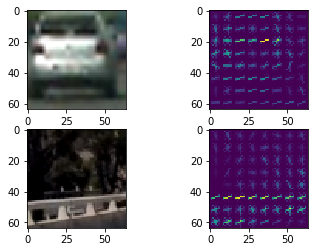

In [4]:
import skimage.feature
from cached_property import cached_property


class HogSettings:
    PIXELS_PER_CELL = 8
    CELLS_PER_BLOCK = 3
    PIXELS_PER_BLOCK = PIXELS_PER_CELL * CELLS_PER_BLOCK


class FeatureExtractor(HogSettings):

    def __init__(self, img):
        self.img = img
    
    @cached_property
    def gray(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)

    def do_hog(self, gray_img, visualise=False, feature_vector=True):
        return skimage.feature.hog(gray_img, block_norm='L2-Hys', visualise=visualise,
                                   feature_vector=feature_vector)

    @cached_property
    def hog(self):
        return self.do_hog(self.gray)
    
    @cached_property
    def hog_viz(self):
        return self.do_hog(self.gray, visualise=True)[1]
    
    @cached_property
    def hog_array(self):
        return self.do_hog(self.gray, feature_vector=False)
    
    def hog_window(self, min_block_x, min_block_y, max_block_x, max_block_y):
        # min and max are *inclusive*
        return self.hog_array[min_block_y:max_block_y + 1, min_block_x:max_block_x + 1].ravel()
    
    def hog_window_viz(self, min_block_x, min_block_y, max_block_x, max_block_y):
        img = self.gray[min_block_y * self.PIXELS_PER_CELL
                        :(max_block_y + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL,
                        min_block_x * self.PIXELS_PER_CELL
                        :(max_block_x + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL]
        
        print(min_block_y * self.PIXELS_PER_CELL)
        print((max_block_y + self.CELLS_PER_BLOCK) * self.PIXELS_PER_CELL)
        print(min_block_x * self.PIXELS_PER_CELL)
        
        return self.do_hog(img, visualise=True)[1]
        #return img


_, axes = plt.subplots(2, 2)
axes[0][0].imshow(vehicles_train[0])
axes[0][1].imshow(FeatureExtractor(vehicles_train[0]).hog_viz)
axes[1][0].imshow(non_vehicles_train[0])
axes[1][1].imshow(FeatureExtractor(non_vehicles_train[0]).hog_viz)
print(FeatureExtractor(vehicles_train[0]).hog.shape[0])
print(6*6*3*3*9)

In [5]:
%%time
x = [FeatureExtractor(im).hog for im in vehicles_train + non_vehicles_train]

CPU times: user 23.1 s, sys: 186 ms, total: 23.3 s
Wall time: 23.3 s


In [6]:
import pickle

def try_load_obj(name, globals_):
    if os.path.exists(f'pickled/{name}'):
        with open(f'pickled/{name}', 'rb') as f:
            globals_()[name] = pickle.load(f)
            return True
    return False

def save_obj(name, obj):
    with open(f'pickled/{name}', 'wb') as f:
        pickle.dump(obj, f)

In [7]:
%%time
import sklearn.svm

if not try_load_obj('clf', globals):
    clf = sklearn.svm.SVC(kernel='linear')

    y = [1] * len(vehicles_train) + [0] * len(non_vehicles_train)

    clf.fit(x, y)
    
    save_obj('clf', clf)

CPU times: user 32.5 ms, sys: 89.5 ms, total: 122 ms
Wall time: 173 ms


In [8]:
%%time
import numpy as np

x_test = [FeatureExtractor(im).hog for im in vehicles_test + non_vehicles_test]
y_test = np.array([1] * len(vehicles_test) + [0] * len(non_vehicles_test))

CPU times: user 7.19 s, sys: 73.1 ms, total: 7.26 s
Wall time: 7.33 s


In [9]:
%%time
yhat_test = clf.predict(x_test)

CPU times: user 1min 31s, sys: 37.3 ms, total: 1min 31s
Wall time: 1min 31s


In [10]:
acc = np.average(yhat_test == y_test)
acc_pct = acc * 100
print(f'Test accuracy: {acc_pct:.2f}%')

Test accuracy: 91.60%


[1.0, 1.4197057572168388, 2.0155644370746373, 2.861508435356379, 4.0625]
410


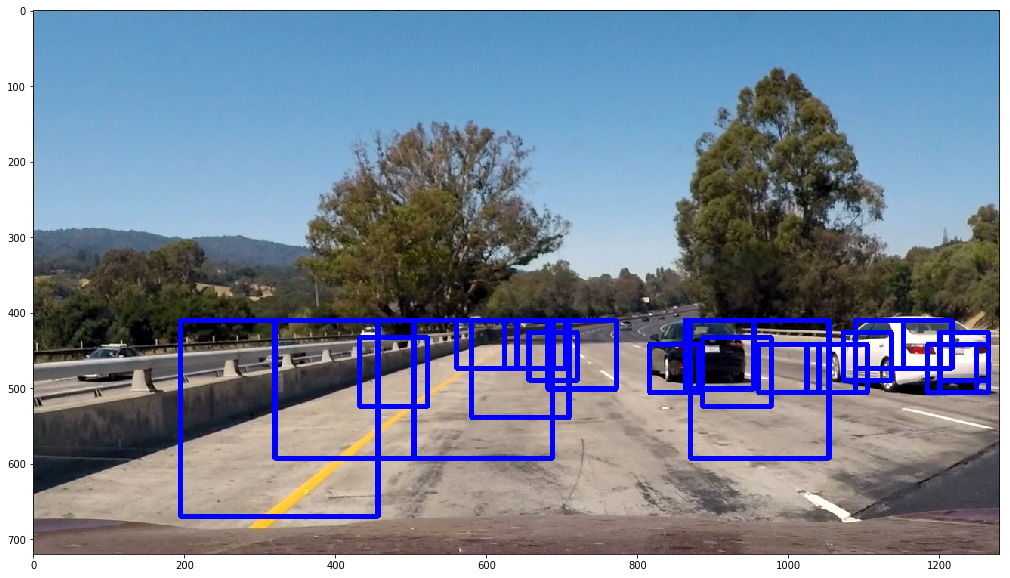

In [11]:
import math

def calc_scales(min, max, num, exp=False):
    # if exp is True, does exponential scales, otherwise linear
    if exp:
        min, max = np.log([min, max])
    x = list(range(num))
    xp = [0, num - 1]
    yp = [min, max]
    rv = np.interp(x, xp, yp)
    if exp:
        rv = np.exp(rv)
    return list(map(float, rv))


class Window:
    def __init__(self, frame_processor, scale_num, min_block_x, min_block_y, max_block_x, max_block_y):
        # min and max are *inclusive*!
        # self.frame_processor = frame_processor
        self.scale_num = scale_num
        self.min_block_x = min_block_x
        self.min_block_y = min_block_y
        self.max_block_x = max_block_x
        self.max_block_y = max_block_y
        
        self.scale = frame_processor.SCALES[self.scale_num]
        
        def map_x(x):
            return int(round(x * frame_processor.PIXELS_PER_CELL * self.scale))
        
        def map_y(y):
            return map_x(y) + frame_processor.MIN_Y
        
        self.upper_left_px = (map_x(min_block_x), map_y(min_block_y))
        self.lower_right_px = (
            map_x(max_block_x) + round(frame_processor.PIXELS_PER_BLOCK * self.scale),
            map_y(max_block_y) + round(frame_processor.PIXELS_PER_BLOCK * self.scale),
        )
    
    def __iter__(self):
        return iter([self.scale_num, self.min_block_x, self.min_block_y, self.max_block_x, self.max_block_y])

    @cached_property
    def bounding_box_px(self):
        return (self.upper_left_px, self.lower_right_px)


class FrameProcessor(HogSettings):
    MIN_Y = 410
    MAX_Y = 670
    # these MIN_X and MAX_X values assume car is in the leftmost lane
    MIN_X = 562  # applies to MIN_Y row
    MAX_X = 1222 # applies to MIN_Y row
    
    MIN_SIZE = 64
    MAX_SIZE = MAX_Y - MIN_Y
    MIN_SCALE = 1
    MAX_SCALE = MAX_SIZE / MIN_SIZE
    NUM_SCALES = 5
    EXP = True
    SCALES = calc_scales(MIN_SCALE, MAX_SCALE, NUM_SCALES, exp=EXP)

    PIXELS_PER_WINDOW = 64
    WINDOW_OVERLAP_CELLS = 2
    CELLS_PER_WINDOW = PIXELS_PER_WINDOW // HogSettings.PIXELS_PER_CELL

    def __init__(self, path=None, img=None):
        if (path is None) == (img is None):
            raise Exception('must pass exactly one of path and img')
        
        if path:
            self.img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        else:
            self.img = img
    
    @cached_property
    def windows_old(self):
        # returns tuples of (scale_num, min_block_x, min_block_y, max_block_x, max_block_y)
        # assumes we're indexing into a scaled version of the cropped image
        rv = []
        for scale_num in range(self.NUM_SCALES):
            scale = self.SCALES[scale_num]
            width = self.img.shape[1] // scale
            height = (self.MAX_Y - self.MIN_Y) // scale
            
            window_step = self.PIXELS_PER_CELL * self.WINDOW_OVERLAP_CELLS
            windows_x = int((width - self.PIXELS_PER_WINDOW) // window_step + 1)
            windows_y = int((height - self.PIXELS_PER_WINDOW) // window_step + 1)
            
            for wx in range(windows_x):
                for wy in range(windows_y):
                    rv.append(Window(
                        self,
                        scale_num,
                        wx * self.WINDOW_OVERLAP_CELLS,
                        wy * self.WINDOW_OVERLAP_CELLS,
                        wx * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                        wy * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                    ))
        
        return rv
    
    @cached_property
    def windows(self):
        # some really hacky optimizations
        rv = []
        for w in self.windows_old:
            # remove windows in the upper left of the image
            lower_right = w.bounding_box_px[1]
            x, y = lower_right
            if y < 681 + (476 - 681) / (582 - 284) * (x - 284):
                continue
            
            # remove too-small windows in lower area of image
            expected_scale = (y - self.MIN_Y) / (self.MAX_Y - self.MIN_Y) * self.SCALES[-1]
            if w.scale < expected_scale - 0.5:
                continue
                
            rv.append(w)

        return rv
    
    def viz_for_window(self, idx):
        rv = np.copy(self.img)
        w = self.windows[idx]
        cv2.rectangle(
            rv,
            *w.bounding_box_px,
            (0, 0, 255),
            thickness=5,
        )
        return rv

    @cached_property
    def windows_viz(self):
        r = random.Random(44)
        rv = np.copy(self.img)
        for w in self.windows:
            if r.random() < 0.9:
                continue

            cv2.rectangle(
                rv,
                *w.bounding_box_px,
                (0, 0, 255),
                thickness=5,
            )

        return rv
    
#     @cached_property
#     def windows_viz_multi(self):
#         rv = np.zeros([self.NUM_SCALES, 4, 720, 1280, 3])
#         for scale_num in range(self.NUM_SCALES):
#             for i in range(4):
#                 img = rv[scale_num][i] = 

fp = FrameProcessor('test_images/test1.jpg')

plt.figure(figsize=(20,10))
plt.imshow(fp.windows_viz)
# plt.imshow(fp.viz_for_window(257))
# _, axes = plt.subplots(10, figsize=(50, 50))
# for idx in range(10):
#     # ax = axes[idx // 2][idx % 2]
#     ax = axes[idx]
#     ax.imshow(fp.viz_for_window(idx))

print(FrameProcessor.SCALES)
print(fp.MIN_Y)

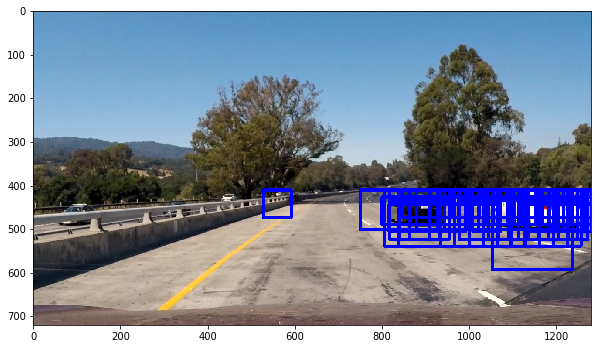

In [12]:
class FrameProcessor2(FrameProcessor):  # bad name, 🤷 ¯\_(ツ)_/¯ 🤷
    @cached_property
    def roi(self):
        return self.img[self.MIN_Y:self.MAX_Y, :]

    @cached_property
    def scaled_rois(self):
        rv = []
        for i, scale in enumerate(self.SCALES):
            width = round(self.roi.shape[1] / scale)
            height = round(self.roi.shape[0] / scale)
            rv.append(cv2.resize(self.roi, (width, height)))
        return rv
    
    @cached_property
    def feature_extractors_per_scale(self):
        return [FeatureExtractor(img=self.scaled_rois[i]) for i in range(self.NUM_SCALES)]
    
    @cached_property
    def windows_with_cars(self):
        rv = []
        for w in self.windows:
            scale_num, min_block_x, min_block_y, max_block_x, max_block_y = w
            feat = self.feature_extractors_per_scale[scale_num].hog_window(
                min_block_x, min_block_y, max_block_x, max_block_y)
            if clf.predict([feat])[0]:
                rv.append(w)
        
        return rv
    
    @cached_property
    def windows_with_cars_viz(self):
        rv = np.copy(self.img)
        for w in self.windows_with_cars:
            cv2.rectangle(
                rv,
                *w.bounding_box_px,
                (0, 0, 255),
                thickness=5,
            )

        return rv
    
    def hog_viz_for_window(self, idx):
        scale_num, min_block_x, min_block_y, max_block_x, max_block_y = self.windows[idx]
        return self.feature_extractors_per_scale[scale_num].hog_window_viz(
            min_block_x, min_block_y, max_block_x, max_block_y
        )

fp = FrameProcessor2('test_images/test1.jpg')
plt.figure(figsize=(10, 20))
#plt.imshow(fp.hog_viz_for_window(257))
plt.imshow(fp.windows_with_cars_viz)

20


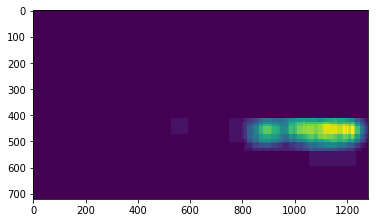

In [13]:
class FrameProcessor3(FrameProcessor2):
    @cached_property
    def heatmap(self):
        rv = np.zeros(self.img.shape[:-1], dtype=np.uint32)
        for w in self.windows_with_cars:
            bbox = w.bounding_box_px
            rv[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
        
        return rv

    @cached_property
    def heatmap_viz(self):
        return (self.heatmap * 255 // np.max(self.heatmap)).astype(np.uint8)


fp = FrameProcessor3('test_images/test1.jpg')
print(np.max(fp.heatmap))
plt.imshow(fp.heatmap_viz)

In [21]:
%%time
from moviepy.editor import VideoFileClip


class CumulativeFrameProcessor:
    FRAME_WINDOW = 10
    THRESHOLD = 100

    def __init__(self):
        self.heatmaps_buffer = []
        self.frame_num = 0

    def process_frame(self, frame):
        hm = FrameProcessor3(img=frame).heatmap
        
        self.heatmaps_buffer.append(hm)
        
        if len(self.heatmaps_buffer) < self.FRAME_WINDOW:
            return np.zeros(frame.shape[:-1])
        
        # TODO optimize
        rv = np.sum(self.heatmaps_buffer, axis=0)
        
        del self.heatmaps_buffer[0]
        self.frame_num += 1
        
        return rv
    
    def process_frame_heatmap_viz(self, frame):
        rv = self.process_frame(frame)
        if np.max(rv) == 0:
            rv = rv.astype(np.uint8)
        else:
            rv = (rv * 255 // np.max(rv)).astype(np.uint8)
        rv = cv2.cvtColor(rv, cv2.COLOR_GRAY2RGB)
        return rv
    
    def process_frame_threshold_viz(self, frame):
        rv = self.process_frame(frame)
        rv = (rv >= self.THRESHOLD) * 255
        rv = cv2.cvtColor(rv, cv2.COLOR_GRAY2RGB)
        return rv


def process_video(inpath, outpath):
    inclip = VideoFileClip(inpath)
    proc = CumulativeFrameProcessor()
    
    outclip = inclip.fl_image(proc.process_frame_heatmap_viz)
    
    outclip.write_videofile(outpath, audio=False)


process_video('test_video.mp4', 'outvid.mp4')    

(720, 1280, 3)
(720, 1280)
(720, 1280)
[MoviePy] >>>> Building video outvid.mp4
[MoviePy] Writing video outvid.mp4



  0%|          | 0/39 [00:00<?, ?it/s]

(720, 1280, 3)



  3%|▎         | 1/39 [00:06<03:48,  6.00s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



  5%|▌         | 2/39 [00:11<03:37,  5.87s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



  8%|▊         | 3/39 [00:17<03:26,  5.73s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 10%|█         | 4/39 [00:23<03:21,  5.75s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 13%|█▎        | 5/39 [00:29<03:21,  5.91s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 15%|█▌        | 6/39 [00:35<03:12,  5.85s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 18%|█▊        | 7/39 [00:40<03:06,  5.83s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 21%|██        | 8/39 [00:46<03:00,  5.82s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 23%|██▎       | 9/39 [00:52<02:54,  5.82s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 26%|██▌       | 10/39 [00:58<02:48,  5.80s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 28%|██▊       | 11/39 [01:03<02:42,  5.79s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 31%|███       | 12/39 [01:09<02:35,  5.78s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 33%|███▎      | 13/39 [01:14<02:29,  5.77s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 36%|███▌      | 14/39 [01:20<02:24,  5.76s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 38%|███▊      | 15/39 [01:26<02:18,  5.77s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 41%|████      | 16/39 [01:31<02:12,  5.74s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 44%|████▎     | 17/39 [01:37<02:05,  5.71s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 46%|████▌     | 18/39 [01:42<01:59,  5.68s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 49%|████▊     | 19/39 [01:47<01:53,  5.65s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 51%|█████▏    | 20/39 [01:52<01:47,  5.63s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 54%|█████▍    | 21/39 [01:57<01:41,  5.61s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 56%|█████▋    | 22/39 [02:03<01:35,  5.62s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 59%|█████▉    | 23/39 [02:08<01:29,  5.61s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 62%|██████▏   | 24/39 [02:14<01:24,  5.61s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 64%|██████▍   | 25/39 [02:19<01:18,  5.59s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 67%|██████▋   | 26/39 [02:25<01:12,  5.58s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 69%|██████▉   | 27/39 [02:30<01:06,  5.57s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 72%|███████▏  | 28/39 [02:35<01:01,  5.56s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 74%|███████▍  | 29/39 [02:40<00:55,  5.54s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 77%|███████▋  | 30/39 [02:46<00:49,  5.55s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 79%|███████▉  | 31/39 [02:52<00:44,  5.55s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 82%|████████▏ | 32/39 [02:59<00:39,  5.60s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 85%|████████▍ | 33/39 [03:07<00:34,  5.67s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 87%|████████▋ | 34/39 [03:14<00:28,  5.73s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 90%|████████▉ | 35/39 [03:20<00:22,  5.74s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 92%|█████████▏| 36/39 [03:26<00:17,  5.74s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 95%|█████████▍| 37/39 [03:32<00:11,  5.75s/it]

(720, 1280)
(720, 1280)
(720, 1280, 3)



 97%|█████████▋| 38/39 [03:39<00:05,  5.76s/it]


(720, 1280)
(720, 1280)
[MoviePy] Done.
[MoviePy] >>>> Video ready: outvid.mp4 

CPU times: user 3min 44s, sys: 1.14 s, total: 3min 45s
Wall time: 3min 45s
